# Exploración visual de datos

El análisis exploratorio de datos (**EDA**) es el proceso de realizar consultas inciales de los datos en un esfuerzo por descubrir patrones, probar hipótesis, resumir características importantes de los datos, e identificar potenciales _outliers_ problemáticos. Este proceso se conduce principalmente por la producción de estadísticos y exploración visual de los datos.

La expansión espacial del EDA es conocida como análisis exploratorio de datos espaciales (**ESDA**), y es una etapa crítica en el _pipeline_ de la ciencia de datos espacial. Es una expansión en el sentido de que el enfoque de un EDA está en entender la correlación entre variables, mientras que ESDA se basa en entender la correlación de las variables con respecto a su ubicación en el espacio.

El primero paso en ESDA es la **cartografía**, o el proceso de creación de mapas. La cartografía es en sí mismo un arte en un sentido en el que toma datos y los representa visualmente de modo que personas tanto técnicas como no-técnicas entiendan y encuentren sentido en los datos; y es una ciencia en un sentido en el que los mapas deben ser derivados de los datos y ser representativos de ellos.

Cabe destacar que no es una práctica común en un EDA convencional, que típicamente se enfoca en las siguientes tareas:

* Estadísticos básicos de los datos
* Entender la distribución de los datos
* Gestión de valores faltantes
* Identificación de _outliers_
* Entender la correlación entre variables

Para ilustrarlo, se contrastan las diferencias de ambos enfoques en un ejemplo que utiliza datos de las listas de **Airbnb de Nueva York** en dos secciones:

* [Análisis exploratorio de datos](#Análisis-exploratorio-de-datos)
* [Análisis exploratorio de datos espaciales](#Análisis-exploratorio-de-datos-espaciales)
    * [Mapa base](#Mapa-base)
    * [Mapas de calor](#Mapas-de-calor)
    * [Mapas censales](#Mapas-censales)

Es importante mencionar que los datos son proporcionados por [Inside Airbnb](http://insideairbnb.com/get-the-data/), y se puede consultar la información de múltiples ciudades

Carga de librerías

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'

import pysal
import splot
import pandas as pd
import matplotlib.pyplot as plt

import contextily
import geopandas as gpd
import geoplot.crs as gcrs
import geoplot as gplt

Ruta relativa a archivo de datos.

Siempre que se carga un archivo de datos es necesario consultar su directorio de datos, o en caso de no contar con ello sería necesario construir uno para mayor entendimiento de los mismos. En el caso de los datos de _Inside Airbnb_ se cuenta con un directorio en la siguiente [liga](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=982310896)

In [2]:
ROOT = os.path.dirname(os.getcwd())
data_path = os.path.join(ROOT, 'data', 'Data pt1')

# Reading in the data - REMINDER: You'll need to download this data yourself from InsideAirbnb
listings = pd.read_csv(
    os.path.join(data_path, 'listings.csv.gz')
    ,compression='gzip')

# Información general
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43566 entries, 0 to 43565
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            43566 non-null  int64  
 1   listing_url                                   43566 non-null  object 
 2   scrape_id                                     43566 non-null  int64  
 3   last_scraped                                  43566 non-null  object 
 4   source                                        43566 non-null  object 
 5   name                                          43566 non-null  object 
 6   description                                   42866 non-null  object 
 7   neighborhood_overview                         25201 non-null  object 
 8   picture_url                                   43566 non-null  object 
 9   host_id                                       43566 non-null 

Para efectos de estas notas, el siguiente paso sería hacer un subconjunto de los datos de modo que queden únicamente algunas variables de interés.

In [3]:
# Aplciación de filtros
listings_sub = listings.filter(
    items=[
        'id', 'property_type', 'neighbourhood_cleansed'
        ,'neighbourhood_group_cleansed', 'beds', 'bathrooms'
        ,'price', 'latitude', 'longitude'])

# Vista previa
listings_sub.head()

,id,property_type,neighbourhood_cleansed,neighbourhood_group_cleansed,beds,bathrooms,price,latitude,longitude
0,2595,Entire rental unit,Midtown,Manhattan,1.0,NaN,$240.00,40.753560,-73.985590
1,5121,Private room in rental unit,Bedford-Stuyvesant,Brooklyn,1.0,NaN,$60.00,40.685350,-73.955120
2,14991,Private room in rental unit,Lower East Side,Manhattan,1.0,NaN,$120.00,40.722070,-73.989760
3,5136,Entire rental unit,Sunset Park,Brooklyn,2.0,NaN,$276.00,40.662650,-73.994540
4,15341,Entire condo,Lower East Side,Manhattan,2.0,NaN,$315.00,40.721359,-73.993668


# Análisis exploratorio de datos

Lo primero que se debe hacer es una inspección general de los datos, su tamaño, valores faltantes.

In [4]:
listings_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43566 entries, 0 to 43565
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            43566 non-null  int64  
 1   property_type                 43566 non-null  object 
 2   neighbourhood_cleansed        43566 non-null  object 
 3   neighbourhood_group_cleansed  43566 non-null  object 
 4   beds                          42765 non-null  float64
 5   bathrooms                     0 non-null      float64
 6   price                         43566 non-null  object 
 7   latitude                      43566 non-null  float64
 8   longitude                     43566 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 3.0+ MB


Lo primero que resalata es que los baños no tienen ningún registro, por lo que no hace ningún tipo de sentido conservarlos para el análisis. Adicionalmente, dado que en la variable `beds` no hay una manera clara de imputar los valores faltantes, se ignora la variable para este análisis.

Por otro lado, no es deseable tener una variable numérica con algún tipo de formato visual que la convierta en una cadena de caracteres, como es el caso de `price`, por ende, se formatea esta columna.

In [5]:
# Secuencia de transformaciones
listings_sub = (
    listings_sub
    .drop(columns=['beds', 'bathrooms'])
    .assign(
        price = lambda _df: _df.price.replace(to_replace='[$,]', value='', regex=True).astype(float))
)

# Vista previa
listings_sub.head()

,id,property_type,neighbourhood_cleansed,neighbourhood_group_cleansed,price,latitude,longitude
0,2595,Entire rental unit,Midtown,Manhattan,240.0,40.753560,-73.985590
1,5121,Private room in rental unit,Bedford-Stuyvesant,Brooklyn,60.0,40.685350,-73.955120
2,14991,Private room in rental unit,Lower East Side,Manhattan,120.0,40.722070,-73.989760
3,5136,Entire rental unit,Sunset Park,Brooklyn,276.0,40.662650,-73.994540
4,15341,Entire condo,Lower East Side,Manhattan,315.0,40.721359,-73.993668


Se observa la distribución general de la variable `precio`

In [6]:
# Estadísticos descriptivos
listings_sub['price'].describe()

count    43566.000000
mean       225.216109
std        818.738268
min          0.000000
25%         80.000000
50%        136.000000
75%        228.000000
max      90120.000000
Name: price, dtype: float64

De los estadísticos básicos se observa que es una distribución con un fuerte sesgo a la derecha presentando lo que posiblemente es una cola larga. Para confirmarlo, se puede realizar un histograma de la variable.

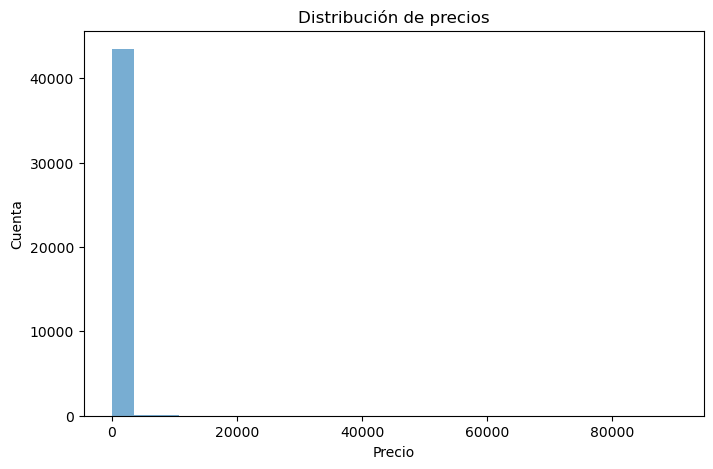

In [7]:
# Especificaciones de figura
fig, ax = plt.subplots(figsize=(8,5))

# Elementos de visualización
ax.hist(
    x=listings_sub.price
    ,bins=25
    ,density=False
    ,alpha=0.6)

# Anotaciones y estilo
ax.set(
    title='Distribución de precios'
    ,xlabel='Precio'
    ,ylabel='Cuenta')

plt.show()

Existe una fuerte anomalía en los datos, por lo que para efectos de un análisis más generalizado, se filtrar aquellos registros con precios menores a $\$9K$ y se repite el histograma

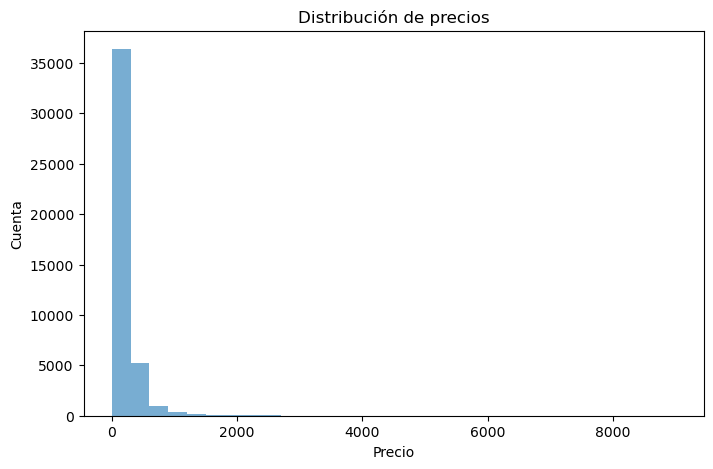

In [8]:
# Filtrado de datos
listings_sub = listings_sub.query("price <= 9_000")

# Especificaciones de figura
fig, ax = plt.subplots(figsize=(8,5))

# Elementos de visualización
ax.hist(
    x=listings_sub.price
    ,bins=30
    ,density=False
    ,alpha=0.6)

# Anotaciones y estilo
ax.set(
    title='Distribución de precios'
    ,xlabel='Precio'
    ,ylabel='Cuenta')

plt.show()

El histograma anterior refleja mejor la distribución de los datos en cuanto al precio se refiere. Si bien se podría continuar con el EDA, no es el propóstio principal en este momento ya que lo que se busca es contrastar las diferencias entre EDA y ESDA.

# Análisis exploratorio de datos espaciales

Para empezar con el **ESDA** lo primero que se debe hacer es convertir los datos a un _GeoDataFrame_, esto es para extraer explícitamente un variable de geometría a la cual se puedan georeferenciar los datos. Hay que recordar que una parte fundamental en la definición de _GeoDataFrames_ es establecer su **CRS**, que en los sistemas modernos, el más convencional es el **4326**

In [9]:
# Convertir geodataframe
listings_sub_gpd = gpd.GeoDataFrame(
    data=listings_sub
    ,geometry=gpd.points_from_xy(
        x=listings_sub.longitude
        ,y=listings_sub.latitude
        ,crs=4326))

## Mapa base

Una vez que se ha construido el _GeoDataFrame_ se pueden empezar a hacer algunos tipos de mapas. En el caso de datos tabulares que provienen de un archivo csv, por lo general la geometría viene a modo de coordenadas en **longitud** y **latitud** asociadas a registros en específico, por lo que al hacer un mapa solo con esta información se vería como puntos distribuidos en el espacio.

Para dar más contexto a la visualización se puede incorporar un mapa base que puede provenir de varias fuentes, por ejemplo:

* Geoplot: Utilizando la función [webmap](https://residentmario.github.io/geoplot/plot_references/plot_reference.html#webmap)
* Contextily: Utilizando la función [add_basemap](https://contextily.readthedocs.io/en/latest/reference.html)

En este caso, se utilizará **contextily**:

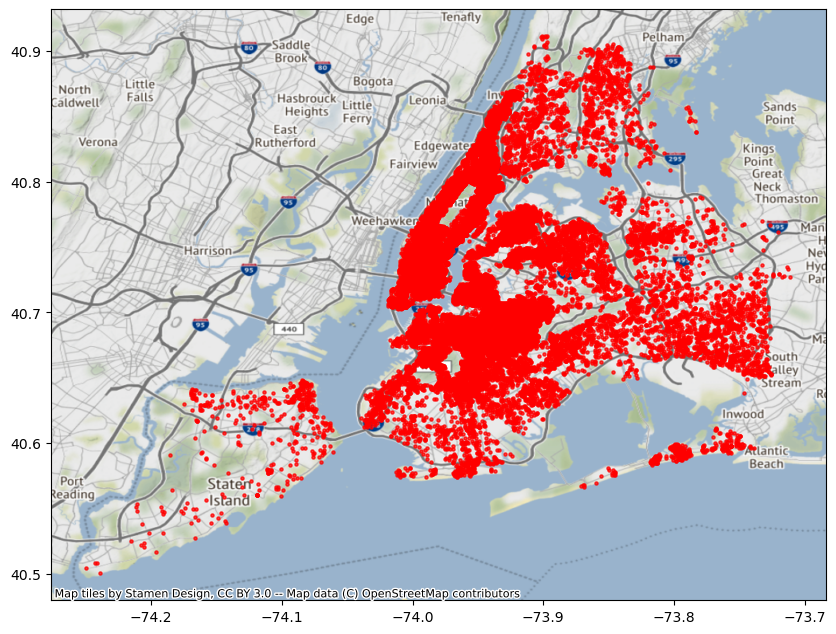

In [10]:
# Especificaciones de figura
fig, ax = plt.subplots(figsize=(10,10))
   
# Elementos de visualización
listings_sub_gpd.plot(
    color='red'
    ,alpha=0.75
    ,markersize=5
    ,ax=ax)

# Agregar mapa base
contextily.add_basemap(
    ax=ax,
    crs=listings_sub_gpd.crs)

## Mapas de calor

Si bien el mapa anterior da una idea general de la distribución espacial de los datos, no es un mapa muy informativo. Una mejor visualización sería utilizando un **mapa de calor** o _heatmap_, que es una tipo de mapa que permite visualizar la densidad de puntos en un área determinada a modo de _raster_.

Como se dijo, la geometría asociada a datos de fuentes tabulares por lo general únicamente son puntos de coordenadas en longitud y latitud. Para construir el mapa de calor primero es necesario **incorporar geometría tipo polígono** al análisis

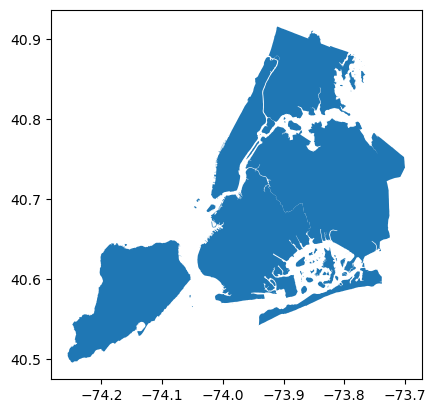

In [11]:
# Cargar fronteras de los condados
Boroughs = gpd.read_file(
    filename=os.path.join(data_path,'NYC Boroughs','nybb_22a','nybb.shp'))

# Cambio de proyección cartográfica
Boroughs = Boroughs.to_crs(crs=4326)

# Visualización sin procesamiento
Boroughs.plot()
plt.show()

Una vez que se tiene la geometría de las fronteras para dar contexto de los datos, entonces ya se puede pasar a graficar el **heatmap** con funciones de `geoplot`.

<Figure size 600x600 with 0 Axes>

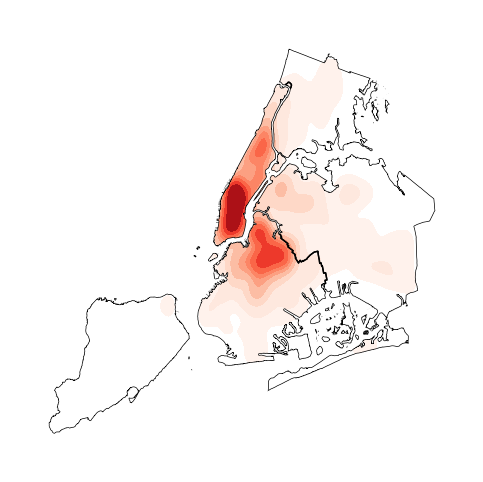

In [12]:
# Especificaciones de figura
fig = plt.figure(figsize=(6,6))

# Elementos de visualización
# ---- Mapa de calor
ax = gplt.kdeplot(
    df=listings_sub_gpd
    ,fill=True
    ,cmap='Reds'
    ,clip=Boroughs.geometry
    ,projection=gcrs.WebMercator())

# ---- Mapa base con fronteras para contexto
gplt.polyplot(
    df=Boroughs
    ,ax=ax
    ,zorder=1)

plt.show()

Del mapa de calor resultante se puede ver con mayor claridad que la mayoría de los datos se concentran en regiones muy específicas utilizando la escala de colores.

## Mapas censales

In [ ]:
# Carga de geometría asociada a NuevaYork
NY_tracts_path = "https://www2.census.gov/geo/tiger/TIGER2021/TRACT/tl_2021_36_tract.zip"
NY_Tracts = gpd.read_file(filename=NY_tracts_path)
NY_Tracts = NY_Tracts.to_crs(crs=4326)

# Carga de datos de CBSA (Core Based Statistical Area) equivalente a AGEB
cbsa_path = 'https://www2.census.gov/geo/tiger/TIGER2021/CBSA/tl_2021_us_cbsa.zip'
cbsas = gpd.read_file(filename=cbsa_path)

# Subconjunto que considera aquellos estados que están en CBSA
NY_cbsa = cbsas[cbsas['GEOID']=='35620']

In [ ]:
# Reading in the New York Census Tracts
NY_tracts_path = "https://www2.census.gov/geo/tiger/TIGER2021/TRACT/tl_2021_36_tract.zip"
NY_Tracts = gpd.read_file(NY_tracts_path)
NY_Tracts = NY_Tracts.to_crs(4326)

# Subsetting the census tracts to those in the New York CBSA
cbsa_path = 'https://www2.census.gov/geo/tiger/TIGER2021/CBSA/tl_2021_us_cbsa.zip'
cbsas = gpd.read_file(cbsa_path)
NY_cbsa = cbsas[cbsas['GEOID']=='35620']

mask = NY_Tracts.intersects(NY_cbsa.loc[620,'geometry'])
NY_Tracts_subset = NY_Tracts.loc[mask]

# Aggregating the airbnb locations to the NY census tracts
NY_Tracts_sj = gpd.sjoin(NY_Tracts_subset, listings_sub_gpd, how='left', op='contains')
NY_Tracts_sj = NY_Tracts_sj[['GEOID','price','geometry']]
NY_Tracts_Agg = NY_Tracts_sj.dissolve(by='GEOID', aggfunc='mean')

NY_Tracts_Agg

In [ ]:
gplt.choropleth(NY_Tracts_Agg, hue="price", cmap="Greens", figsize=(60,30), legend=True)

In [ ]:
import geoviews
geoviews.extension("bokeh")

choropleth = geoviews.Polygons(data=NY_Tracts_Agg, vdims=["price","GEOID"])

choropleth.opts(height=600, width=900, title="NYC Airbnb Price",
                tools=["hover"], cmap="Greens", colorbar=True, colorbar_position="bottom")

In [ ]:
import statistics

# Calculating the mean and standard deviation
mean_price = statistics.mean(NY_Tracts_Agg['price'].dropna())
stdev = statistics.stdev(NY_Tracts_Agg['price'].dropna())

print("The mean Airbnb price is: % s " % (round(mean_price, 2)))
print("The standard deviation of Airbnb prices is: % s " % (round(stdev, 2)))

# Droping records that are more than 1 standard deviation from the mean
NY_Tracts_Agg_filtered = NY_Tracts_Agg[NY_Tracts_Agg['price'] < mean_price+stdev]

choropleth = geoviews.Polygons(data=NY_Tracts_Agg_filtered, vdims=["price","GEOID"])

choropleth.opts(height=600, width=900, title="NYC Airbnb Price",
                tools=["hover"], cmap="Greens", colorbar=True, colorbar_position="bottom")